In [2]:
# Preperare distributed
using Distributed
addprocs(Sys.CPU_THREADS - nprocs() - 1)
print("Number of workers: ", nprocs(), "\nNumber of CPU threads: ", Sys.CPU_THREADS, "\n")

using JLD2
using Printf

@everywhere using LoopVectorization
using BenchmarkTools

@everywhere using Plots
include("distributed_gif.jl")

using Base.Threads
print("Number of threads: ", Threads.nthreads(), "\n") # Check number of threads available

Number of workers: 5
Number of CPU threads: 6
Number of threads: 6


In [1]:
N = 100
L = 1.0
dx = L / N
D = 1.0
dt = 0.00001
c_0 = zeros(N, N)
c_0[:, end] .= 1.0

100-element view(::Matrix{Float64}, :, 100) with eltype Float64:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

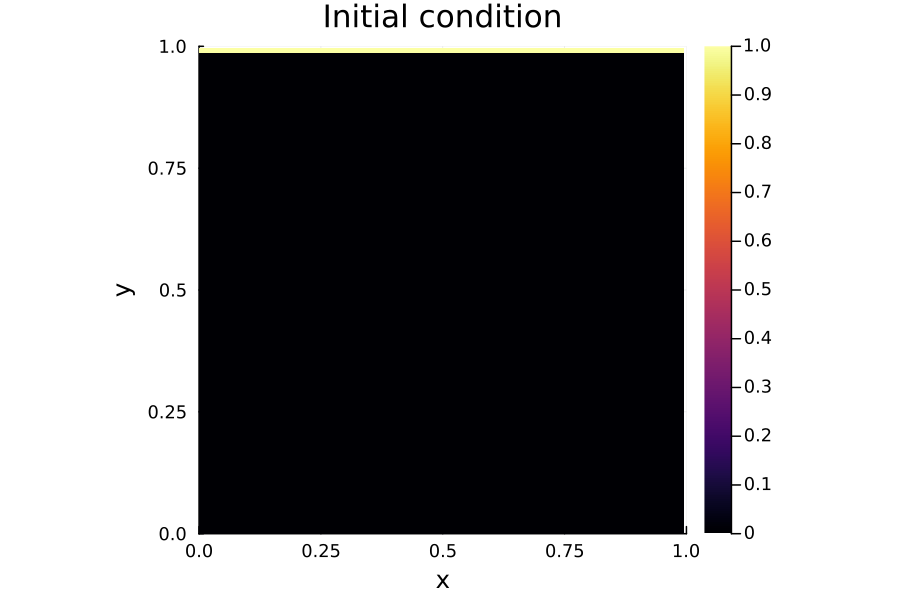

In [3]:
# Plotting parameters
ticks = (1:N/4:N+1, 0:L/4:L)
lims = (1, N + 1)
heatmap_kwargs = Dict(
    :aspect_ratio => 1,
    :xlabel => "x",
    :ylabel => "y",
    :xticks => ticks,
    :yticks => ticks,
    :xlims => lims,
    :ylims => lims,
    :dpi => 150
)

heatmap_kwargs
heatmap(c_0', title="Initial condition"; heatmap_kwargs...)

In [5]:
do_bench = true

true

In [14]:
function c_next_jacobi(c::Matrix{Float64})
    N = size(c, 1)
    c_new = similar(c)

    # Apply boundary conditions
    c_new[:, 1] .= 0.0  # Bottom boundary
    c_new[:, end] .= 1.0  # Top boundary

    Fo = 0.25

    @inbounds @turbo for i in 2:N-1, j in 2:N-1
        c_new[i, j] = Fo * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
    end

    # Periodic in x-direction
    @inbounds for j in 2:N-1
        c_new[1, j] = Fo * (c[2, j] + c[N, j] + c[1, j+1] + c[1, j-1])
        c_new[N, j] = Fo * (c[1, j] + c[N-1, j] + c[N, j+1] + c[N, j-1])
    end

    return c_new
end
if do_bench
    @benchmark c_next_jacobi($c_0)
end

BenchmarkTools.Trial: 10000 samples with 8 evaluations per sample.
 Range (min … max):  3.370 μs … 117.537 μs  ┊ GC (min … max):  0.00% … 93.87%
 Time  (median):     3.859 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   4.991 μs ±   7.758 μs  ┊ GC (mean ± σ):  20.21% ± 12.11%

  █▄                                                          ▁
  ███▇▇▅▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▇█ █
  3.37 μs      Histogram: log(frequency) by time      58.7 μs <

 Memory estimate: 80.08 KiB, allocs estimate: 3.

In [ ]:
function c_next_gauss_seidel!(c::Matrix{Float64})
    N = size(c, 1)

    # Apply boundary conditions
    Fo = 0.25

    @inbounds for i in 2:N-1
        for j in 2:N-1
            c[i, j] = Fo * (c[i+1, j] + c[i-1, j] + c[i, j+1] + c[i, j-1])
        end
    end

    # Periodic in x-direction
    @inbounds for j in 2:N-1
        c[1, j] = Fo * (c[2, j] + c[N, j] + c[1, j+1] + c[1, j-1])
        c[N, j] = Fo * (c[1, j] + c[N-1, j] + c[N, j+1] + c[N, j-1])
    end
end
if do_bench
    @benchmark c_next_gauss_seidel!($c_0)
end

In [ ]:
function stopping_condition(c_old::Matrix{Float64}, c_new::Matrix{Float64}, tol::Float64)
    return maximum(abs.(c_new .- c_old)) < tol
end

5.0e-6